In [449]:
import pandas as pd
import numpy
import sys
import nltk
nltk.download('punkt')
import re
import unicodecsv as csv
import random
import matplotlib.pyplot as plt
from nltk import FreqDist
import math

from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, Activation
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.models import load_model

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pascalequeralt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [182]:
raw_data = pd.read_csv("pascale_cluster-2.csv")
raw_data.head()

,Unnamed: 0,tweet,cluster
0,8,Economists on the TAX CUTS and JOBS ACT:\n\n“T...,8
1,13,The media has been speculating that I fired Re...,13
2,5,RT @WhiteHouse: President Trump proclaims toda...,5
3,8,Republicans Senators are working hard to pass ...,8
4,0,The jury was not told the killer of Kate was a...,0


## Visualize Length of Tweets

* We know Twitter used to have a 140 char limit, now it has been raised to 280
* When considering generating tweets, must generate a particular number of words and subsequent characters
* Rather than generating an arbitrary num of characters between [140,280] or even [0,280] (which would create far too many super short tweets), generate a length based on Trump's typical usage

In [183]:
raw_data['length'] = raw_data.apply(lambda x: len(x.tweet), axis=1)
raw_data.head()

,Unnamed: 0,tweet,cluster,length
0,8,Economists on the TAX CUTS and JOBS ACT:\n\n“T...,8,231
1,13,The media has been speculating that I fired Re...,13,275
2,5,RT @WhiteHouse: President Trump proclaims toda...,5,113
3,8,Republicans Senators are working hard to pass ...,8,279
4,0,The jury was not told the killer of Kate was a...,0,173


In [443]:
raw_data['length'].describe()

count    4824.000000
mean      129.615257
std        37.425821
min         2.000000
25%       118.000000
50%       138.000000
75%       142.000000
max       328.000000
Name: length, dtype: float64

The longest char tweet is likely due to a URL at the end of the tweet (which does not count towards character len).  Still think it's best to cap at 280 regardless of these exceptions

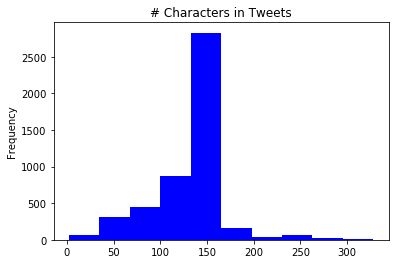

In [184]:
raw_data['length'].plot.hist(title="# Characters in Tweets", color='b')
plt.show()

In [473]:
def get_tweet_length():
    tweet_len_dist = raw_data['length'].value_counts()
    total_tweets = tweet_len_dist.sum()
    p = tweet_len_dist/total_tweets
    
    index = numpy.random.multinomial(1,p,1).argmax()
    return tweet_len_dist.index.values[index]

## Visualize number of words per tweet

* This might be insightful in tuning the seq_length parameter

In [434]:
raw_data['num_words'] = raw_data.apply(lambda x: len(x.tweet.split()), axis=1)
raw_data.head()

,Unnamed: 0,tweet,cluster,length,num_words
0,8,Economists on the TAX CUTS and JOBS ACT:\n\n“T...,8,231,36
1,13,The media has been speculating that I fired Re...,13,275,46
2,5,RT @WhiteHouse: President Trump proclaims toda...,5,113,10
3,8,Republicans Senators are working hard to pass ...,8,279,51
4,0,The jury was not told the killer of Kate was a...,0,173,35


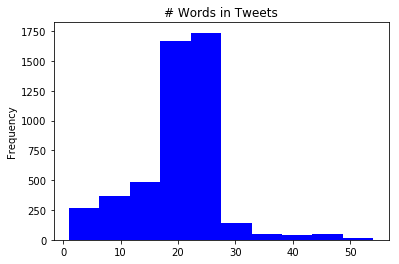

In [436]:
raw_data['num_words'].plot.hist(title="# Words in Tweets", color='b')
plt.show()

In [442]:
raw_data['num_words'].describe()

count    4824.000000
mean       20.350332
std         7.330445
min         1.000000
25%        17.000000
50%        22.000000
75%        24.000000
max        54.000000
Name: num_words, dtype: float64

* On average, 20 words/tweet 
* interesting to see one tweet is only 1 word long - keep in mind that any tweets < seq_length set will not be trained on at all. This is probably ok if seq_length < 17. Any higher than 17 would cause loss of 25% of tweets (if using version 1 of building training set)

##  Grab Tweets related to a particular topic cluster 

In [187]:
CLUSTER = 10 #Test with Hillary Clinton tweets 

clustered_data = raw_data.loc[raw_data['cluster'] == CLUSTER]['tweet']
clustered_data.head()

15    The Failing @nytimes has totally gone against ...
17    Funny to hear the Democrats talking about the ...
18    “Had the information (Crooked Hillary’s emails...
20    The House of Representatives seeks contempt ci...
42    Charles McCullough, the respected fmr Intel Co...
Name: tweet, dtype: object

## Do some data cleanup 

In [381]:
tweets = []
for i in clustered_data: 
    i = re.sub(r"http\S+", "", i) #remove all URLs
    i = re.sub(r"amp\S+", "", i) #remove all amps following &
    i = re.sub(r"“", '"', i) #standardize punctuation
    i = re.sub(r"”", '"', i)
    i = re.sub(r"’", "'", i)
    i = re.sub(r"‘", "'", i)
    i = re.sub(r"…", "...", i)
    tweets.append(i)

In [382]:
print 'Total number of tweets in CLUSTER ', CLUSTER, ":", len(tweets)
print '\nFirst 10 tweets: ', tweets[0:10]
numpy.savetxt('tweets.txt', tweets, fmt='%s')

Total number of tweets in CLUSTER  10 : 356

First 10 tweets:  ['The Failing @nytimes has totally gone against the Social Media Guidelines that they installed to preserve some credibility after many of their biased reporters went Rogue!  @foxandfriends', 'Funny to hear the Democrats talking about the National Debt when President Obama doubled it in only 8 years!', '"Had the information (Crooked Hillary\'s emails) been released there would have been harm to National Security...."\nCharles McCullough\nFmr Intel Comm Inspector General ', 'The House of Representatives seeks contempt citations(?) against the JusticeDepartment and the FBI for withholding key documents and an FBI witness which could shed light on surveillance of associates of Donald Trump. Big stuff. Deep State. Give this information NOW! @FoxNews', 'Charles McCullough, the respected fmr Intel Comm Inspector General, said public was misled on Crooked Hillary Emails. "Emails endangered National Security." Why aren\'t our deep 

## Tokenize words

In [383]:
# create mapping of unique chars to integers
all_text = ' '.join(tweets).decode('utf-8')

chars = sorted(list(set(all_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
print char_to_int
# for c in char_to_int:
#     print c

{u'\u27a1': 79, u'\n': 0, u'\ufe0f': 80, u'!': 2, u' ': 1, u'#': 4, u'"': 3, u'%': 6, u'$': 5, u"'": 8, u'&': 7, u')': 10, u'(': 9, u'-': 12, u',': 11, u'/': 14, u'.': 13, u'1': 16, u'0': 15, u'3': 18, u'2': 17, u'5': 20, u'4': 19, u'7': 22, u'6': 21, u'9': 24, u'8': 23, u':': 25, u'?': 26, u'A': 28, u'@': 27, u'C': 30, u'B': 29, u'E': 32, u'D': 31, u'G': 34, u'F': 33, u'I': 36, u'H': 35, u'K': 38, u'J': 37, u'M': 40, u'L': 39, u'O': 42, u'N': 41, u'Q': 44, u'P': 43, u'S': 46, u'R': 45, u'U': 48, u'T': 47, u'W': 50, u'V': 49, u'Y': 52, u'X': 51, u'a': 53, u'c': 55, u'b': 54, u'e': 57, u'd': 56, u'g': 59, u'f': 58, u'i': 61, u'h': 60, u'k': 63, u'j': 62, u'm': 65, u'l': 64, u'o': 67, u'n': 66, u'q': 69, u'p': 68, u's': 71, u'r': 70, u'u': 73, u't': 72, u'w': 75, u'v': 74, u'y': 77, u'x': 76, u'z': 78}


In [386]:
words = re.findall(r'[\w+]+|[*"*.,!?;@*"*]', all_text)

tweets_tokenized = []
for tweet in tweets: 
    tweet = re.findall(r'[\w+]+|[*"*.,!?;@*"*]', tweet)
    tweets_tokenized.append(tweet)

In [391]:
for tweet in tweets_tokenized[0:10]:
   print tweet

['The', 'Failing', '@', 'nytimes', 'has', 'totally', 'gone', 'against', 'the', 'Social', 'Media', 'Guidelines', 'that', 'they', 'installed', 'to', 'preserve', 'some', 'credibility', 'after', 'many', 'of', 'their', 'biased', 'reporters', 'went', 'Rogue', '!', '@', 'foxandfriends']
['Funny', 'to', 'hear', 'the', 'Democrats', 'talking', 'about', 'the', 'National', 'Debt', 'when', 'President', 'Obama', 'doubled', 'it', 'in', 'only', '8', 'years', '!']
['"', 'Had', 'the', 'information', 'Crooked', 'Hillary', 's', 'emails', 'been', 'released', 'there', 'would', 'have', 'been', 'harm', 'to', 'National', 'Security', '.', '.', '.', '.', '"', 'Charles', 'McCullough', 'Fmr', 'Intel', 'Comm', 'Inspector', 'General']
['The', 'House', 'of', 'Representatives', 'seeks', 'contempt', 'citations', '?', 'against', 'the', 'JusticeDepartment', 'and', 'the', 'FBI', 'for', 'withholding', 'key', 'documents', 'and', 'an', 'FBI', 'witness', 'which', 'could', 'shed', 'light', 'on', 'surveillance', 'of', 'associat

In [446]:
# create mapping of unique words to integers
unique_words = sorted(list(set(words)))
word_to_int = dict((w, i) for i, w in enumerate(unique_words))
int_to_word = dict((i, w) for i, w in enumerate(unique_words))
print word_to_int

{u'all': 446, u'Based': 67, u'pardon': 918, u'washed': 1184, u'Workers': 416, u'PRETEND': 280, u'dollar': 615, u'fabricated': 657, u'month': 863, u'HOAX': 181, u'obstruction': 893, u'Take': 362, u'Department': 123, u'Indiana': 197, u'involved': 782, u'decisions': 588, u'magnifying': 837, u'poorly': 939, u'Foundation': 164, u'supposedly': 1103, u'haters': 726, u'Watch': 403, u'Caputo': 85, u'to': 1145, u'charge': 531, u'does': 613, u'wants': 1182, u'under': 1165, u'Not': 270, u'TRAITOR': 361, u'Now': 272, u'sent': 1045, u'@': 30, u'family': 665, u'lack': 796, u'rejected': 995, u'hacked': 713, u'advantage': 437, u'without': 1210, u'far': 666, u'continues': 564, u'pays': 922, u'focus': 682, u'liability': 814, u'every': 645, u'overplaying': 916, u'trouble': 1155, u'minute': 855, u'debates': 587, u'Just': 217, u'presented': 948, u'did': 600, u'turns': 1161, u'who': 1200, u'Tax': 363, u'brother': 513, u'standards': 1084, u'deals': 585, u'Manning': 241, u'race': 978, u'team': 1116, u'Why': 41

In [50]:
print word_to_int

{u'all': 455, u'Based': 69, u'pardon': 925, u'washed': 1191, u'Workers': 425, u'PRETEND': 289, u'dollar': 622, u'fabricated': 664, u'month': 870, u'HOAX': 186, u'obstruction': 900, u'Take': 371, u'Department': 128, u'Indiana': 204, u'involved': 789, u'decisions': 595, u'magnifying': 844, u'poorly': 946, u'Foundation': 169, u'supposedly': 1110, u'haters': 733, u'Watch': 412, u'Caputo': 88, u'to': 1153, u'charge': 540, u'does': 620, u'wants': 1189, u'under': 1173, u'Not': 278, u'TRAITOR': 370, u'Now': 280, u'sent': 1052, u'adviser': 447, u'family': 672, u'lack': 804, u'rejected': 1002, u'hacked': 720, u'advantage': 446, u'without': 1219, u'far': 673, u'continues': 573, u'pays': 929, u'focus': 689, u'liability': 822, u'every': 652, u'overplaying': 923, u'trouble': 1163, u'minute': 862, u'debates': 594, u'Just': 225, u"Don't": 137, u'did': 607, u'turns': 1169, u'who': 1208, u'Tax': 372, u'brother': 522, u'standards': 1091, u'deals': 592, u'Manning': 249, u'race': 985, u'team': 1123, u'Sw':

NOTE: Consider removing the random characters that appear at the end and may only confuse the model

In [429]:
n_words = len(words)
n_vocab = len(unique_words)
print "Total Words: ", n_words
print "Total Vocab: ", n_vocab

Total Words:  9666
Total Vocab:  1231


NOTE: Typical book length that generates good results is around 150,000 characters (when doing a character by character RNN generation)

## Build training set

### Version 1: Separate by tweet

* Creates training set of sum of the lengths of all tweets - num_tweets * seq_length
* This produces a smaller data set, but I hypothesize a data set of more value because of the grouping of words discreetly by tweet (thematically discreet training) 

In [424]:
#words = array of all words and punctuation in the corpus 
#n_words = # of total words in text 
#n_vocab = # of unique words in text 

seq_length = 5

num = 0
for tweet in tweets_tokenized:
    num += len(tweet) - seq_length
#print num

X_version_bytweet = numpy.zeros((num, seq_length, n_vocab))
y_version_bytweet = numpy.zeros((num, seq_length, n_vocab))

index = 0;
for tweet in tweets_tokenized:
    #print '------------NEXT TWEET--------------'
    n_words = len(tweet)
    #print n_words
    
    #print 'limit: ', n_words-seq_length
    for i in range(0, n_words-seq_length, 1):
        #print index
        X_sequence = tweet[i:i+seq_length]
        X_sequence_ix = [word_to_int[value] for value in X_sequence]
        input_sequence = numpy.zeros((seq_length, n_vocab))
        for j in range(seq_length):
            input_sequence[j][X_sequence_ix[j]] = 1.
        X_version_bytweet[index] = input_sequence

        y_sequence = tweet[i+1:i+seq_length+1]
        y_sequence_ix = [word_to_int[value] for value in y_sequence]
        target_sequence = numpy.zeros((seq_length, n_vocab))
        for j in range(seq_length):
            target_sequence[j][y_sequence_ix[j]] = 1.
        y_version_bytweet[index] = target_sequence

        index += 1
        #print 'input seq: ', X_sequence
        #print 'output seq: ', y_sequence
        

n_patterns = len(X_version_bytweet)
print "Total Patterns: ", n_patterns

Total Patterns:  7886


### Version 2: No distinction between tweets

* Creates training set of length n_words - seq_length 
* The training set for this version is longer, but potentially less coherent since tweets can run into each other

In [431]:
#words = array of all words and punctuation in the corpus 
#n_words = # of total words in text 
#n_vocab = # of unique words in text 

seq_length = 5

X_version_byalltext = numpy.zeros((n_words-seq_length, seq_length, n_vocab))
y_version_byalltext = numpy.zeros((n_words-seq_length, seq_length, n_vocab))

#print n_words

for i in range(0, n_words-seq_length-1, 1):
    X_sequence = words[i:i+seq_length]
    X_sequence_ix = [word_to_int[value] for value in X_sequence]
    input_sequence = numpy.zeros((seq_length, n_vocab))
    for j in range(seq_length):
        input_sequence[j][X_sequence_ix[j]] = 1.
    X_version_byalltext[i] = input_sequence

    y_sequence = words[i+1:i+seq_length+1]
    y_sequence_ix = [word_to_int[value] for value in y_sequence]
    target_sequence = numpy.zeros((seq_length, n_vocab))
    for j in range(seq_length):
        target_sequence[j][y_sequence_ix[j]] = 1.
    y_version_byalltext[i] = target_sequence
    
    #print 'input seq: ', X_sequence
    #print 'output seq: ', y_sequence
    #print i

n_patterns = len(X_version_byalltext)
print "Total Patterns: ", n_patterns

Total Patterns:  9661


## Generate Tweets from a model!

In [483]:
def generate_words(model):
    max_length = get_tweet_length() # in characters
    
    ix = [numpy.random.randint(n_vocab)]
    y_char = [int_to_word[ix[-1]]]
    X = numpy.zeros((1, max_length, n_vocab))
    
    punct_chars = set('.,;?!')
    
    char_length = len(y_char[0])
    i = 0
    while char_length < max_length:
        X[0, i, :][ix[-1]] = 1
        #print(int_to_word[ix[-1]])
        ix = numpy.argmax(model.predict(X[:, :i+1, :])[0], 1)
        next_word = int_to_word[ix[-1]]
        y_char.append(next_word)
        
        if next_word in punct_chars: 
            char_length += len(next_word)
        else: 
            char_length += len(next_word) + 1
        i += 1
    print 'total chars: ', char_length
    return y_char

In [480]:
def join_punctuation(seq, characters='.,;?!'):
    characters = set(characters)
    seq = iter(seq)
    current = next(seq)

    for nxt in seq:
        if nxt in characters:
            current += nxt
        else:
            yield current
            current = nxt

    yield current

def output_as_sentence(words):
    print ' '.join(join_punctuation(words))

## Load pre-trained model from file

In [459]:
# load the network weights
filename = "checkpoint_700_epoch_30.hdf5"
model = create_model()
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

output_as_sentence(generate_words(model))

ValueError: Dimension 0 in both shapes must be equal, but are 1231 and 1240 for 'Assign_2' (op: 'Assign') with input shapes: [1231,2800], [1240,2800].

## Train Model

In [461]:
def create_model(HIDDEN_DIM, LAYER_NUM):
    #HIDDEN_DIM = 700
    #LAYER_NUM = 3

    model = Sequential()
    model.add(LSTM(HIDDEN_DIM, input_shape=(None, n_vocab), return_sequences=True))
    for i in range(LAYER_NUM - 1):
        model.add(LSTM(HIDDEN_DIM, return_sequences=True))
    model.add(TimeDistributed(Dense(n_vocab)))
    model.add(Activation('softmax'))
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop")
    
    return model

In [ ]:
BATCH_SIZE = 128
HIDDEN_DIM = 700
LAYER_NUM = 3 
nb_epoch = 0

model1 = create_model(HIDDEN_DIM, LAYER_NUM)

for i in range (0,200):
    print('\n\n')
    model1.fit(X_version_bytweet, y_version_bytweet, batch_size=BATCH_SIZE, verbose=1, nb_epoch=1)
    nb_epoch += 1
    output_as_sentence(generate_words(model1))
    if nb_epoch % 10 == 0:
        model1.save_weights('model1/checkpoint_{}_epoch_{}.hdf5'.format(HIDDEN_DIM, nb_epoch))
        model1.save('model1/checkpoint_{}_epoch_{}.h5'.format(HIDDEN_DIM, nb_epoch))




Epoch 1/1
7886/7886 [==============================] - 180s - loss: 6.0150   
total chars:  34
statement the.....................



Epoch 1/1
7886/7886 [==============================] - 5650s - loss: 5.5184  
total chars:  132
know................................................................................................................................



Epoch 1/1
7886/7886 [==============================] - 17186s - loss: 5.0374   
total chars:  100
crimes........... the Dems, the the,,,,,,,,,,, the........... the Dems, the the,,,,,,,,,, that was..



Epoch 1/1
7886/7886 [==============================] - 8785s - loss: 4.5400   
total chars:  146
TuckerCarlson, the Administration that the Comey investigation, the Comey story, 000, the FBI and.................................................



Epoch 1/1
7886/7886 [==============================] - 178s - loss: 4.1052   
total chars:  139
learning the election. What have a wrong and hacking equipment, Russia.................

7886/7886 [==============================] - 164s - loss: 0.6042   
total chars:  143
service. He came to the c during my run c c go????????????????????????????????!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! for!! for for!



Epoch 1/1
7886/7886 [==============================] - 164s - loss: 0.6040   
total chars:  139
He came to the c during my run against Crooked??????????????????????????????????????!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



Epoch 1/1
7886/7886 [==============================] - 165s - loss: 0.6013   
total chars:  62
subscribers for the poor reporting it did on my election! Lets



Epoch 1/1
7886/7886 [==============================] - 164s - loss: 0.6003   
total chars:  133
Barron Trump Russia,.................................................................................................................



Epoch 1/1
7886/7886 [==============================] - 164s - loss: 0.5984   
total chars:  161
other words, Russia was against Trump 

7886/7886 [==============================] - 189s - loss: 0.5641   
total chars:  145
zero proof, so now they go for obstruction of justice on the phony story s!!? " Who gave gave have have " " " " " " " " " " " President President



Epoch 1/1
7886/7886 [==============================] - 190s - loss: 0.5619   
total chars:  147
Spied on before nomination. " The real story...................... is is is of of of of of of of of the the Crooked Crooked Crooked Crooked Crooked



Epoch 1/1
7886/7886 [==============================] - 198s - loss: 0.5600   
total chars:  146
Amazon Washington Post, this time against A. G. Hillary s................... Facebook with with Crooked Crooked or acid Dems of Crooked. Wrong....



Epoch 1/1
7886/7886 [==============================] - 184s - loss: 0.5608   
total chars:  137
its subscribers, right after the election, because all totally why no " " like candy. President President was,...........................



Epoch 1/1
7886/7886 [==============